In [1]:
import crowsetta
import hdf5storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import numpy as np
from tqdm.notebook import tqdm
import yaml
from yaml.loader import SafeLoader

In [2]:
ALPHAN_NUMERIC = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz';

In [3]:
data_path = r'C:\Users\sivanle.WISMAIN\Dropbox (Weizmann Institute)\lb4444\lb4444 - Spring2019 - part 1\lb4444_1_annotation_July_2019_Vika.mat'

### trying to use crowsetta

In [27]:
def create_syl_df_from_annot_file(file_path):
    scribe = crowsetta.Transcriber(format='yarden')
    audseq = scribe.from_file(file_path)
    annots = audseq.to_annot()
    records = []
    for annot in annots:
        curr_path = str(annot.notated_path)
        prev_segment = None
        for segment in annot.seq.segments:
            time_from_prev = None
            if prev_segment:
                time_from_prev = segment.onset_s - prev_segment.offset_s
            records.append(
                {
                    'path': curr_path,
                    'label': segment.label,
                    'duration': segment.offset_s - segment.onset_s,
                    'start': segment.onset_s,
                    'end': segment.offset_s,
                    'time_from_prev': time_from_prev

                }
            )
            prev_segment = segment
    return pd.DataFrame.from_records(records)


In [28]:
df = create_syl_df_from_annot_file(data_path)

In [29]:
df.head()

,path,label,duration,start,end,time_from_prev
0,lb4444_00001_2019_05_21_10_52_58.wav,1,0.038,0.027,0.065,NaN
1,lb4444_00001_2019_05_21_10_52_58.wav,1,0.041,0.097,0.138,0.032
2,lb4444_00001_2019_05_21_10_52_58.wav,1,0.038,0.170,0.208,0.032
3,lb4444_00001_2019_05_21_10_52_58.wav,1,0.040,0.243,0.283,0.035
4,lb4444_00001_2019_05_21_10_52_58.wav,1,0.037,0.316,0.353,0.033


Text(0.5, 1.0, 'labels histogram')

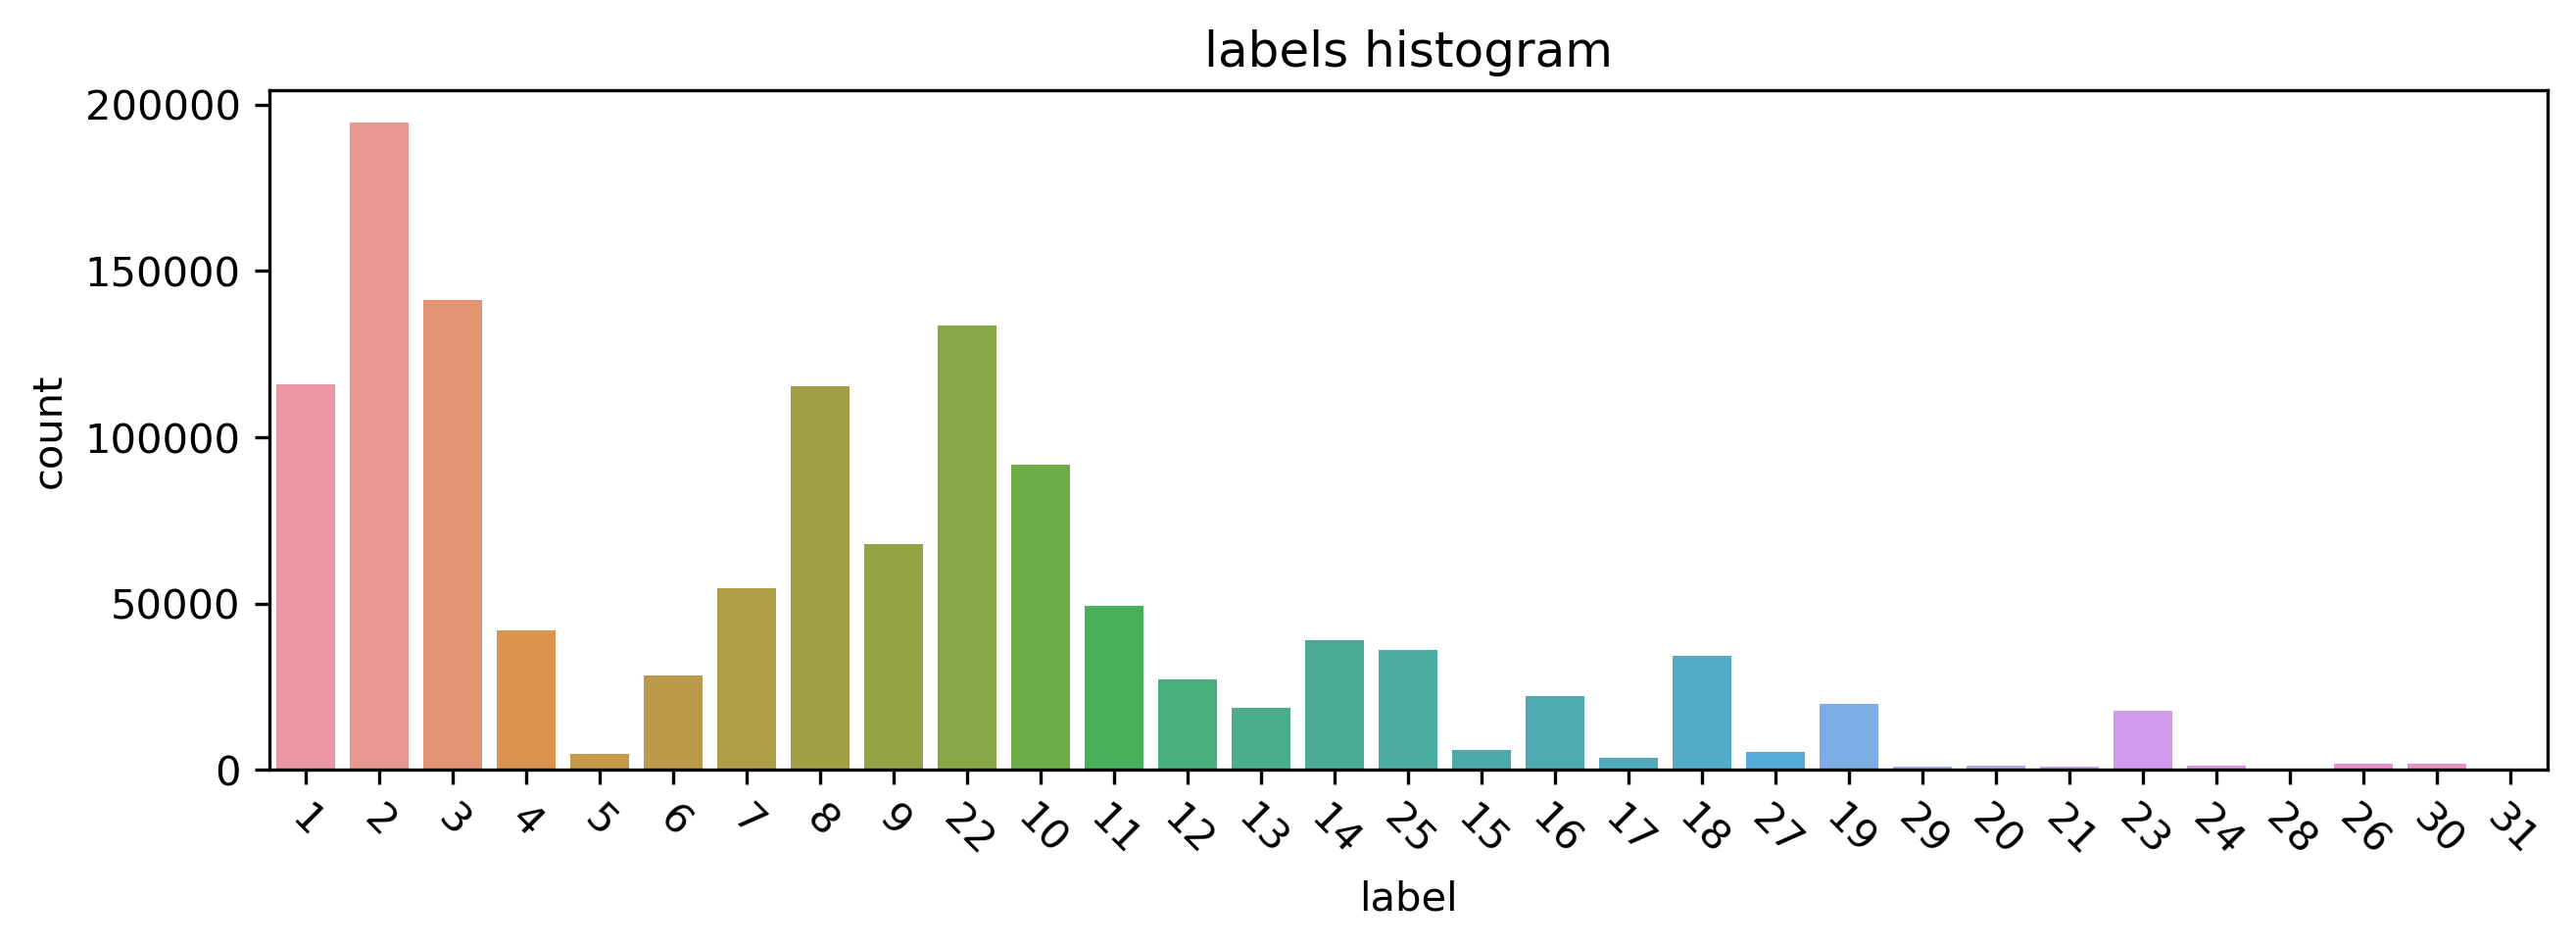

In [30]:
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
sns.countplot(data=df[['label']], x='label', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = -45)
ax.set_title('labels histogram')

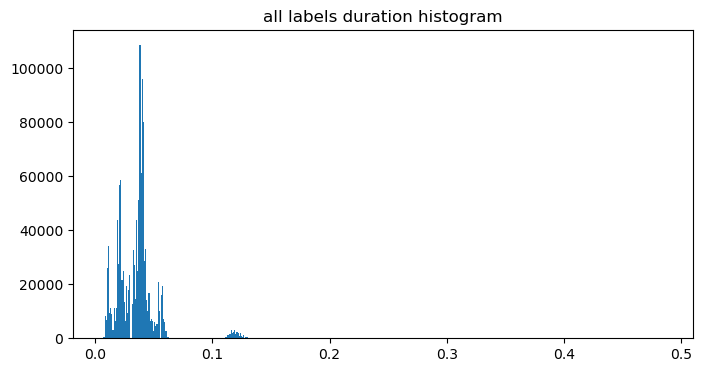

In [31]:
fig, _= plt.subplots(figsize=(8,4),dpi=100)
plt.hist(df[['duration']],bins = 500)
plt.title('all labels duration histogram')
plt.show()

Text(0.5, 1.0, 'violin plot of duration for each label')

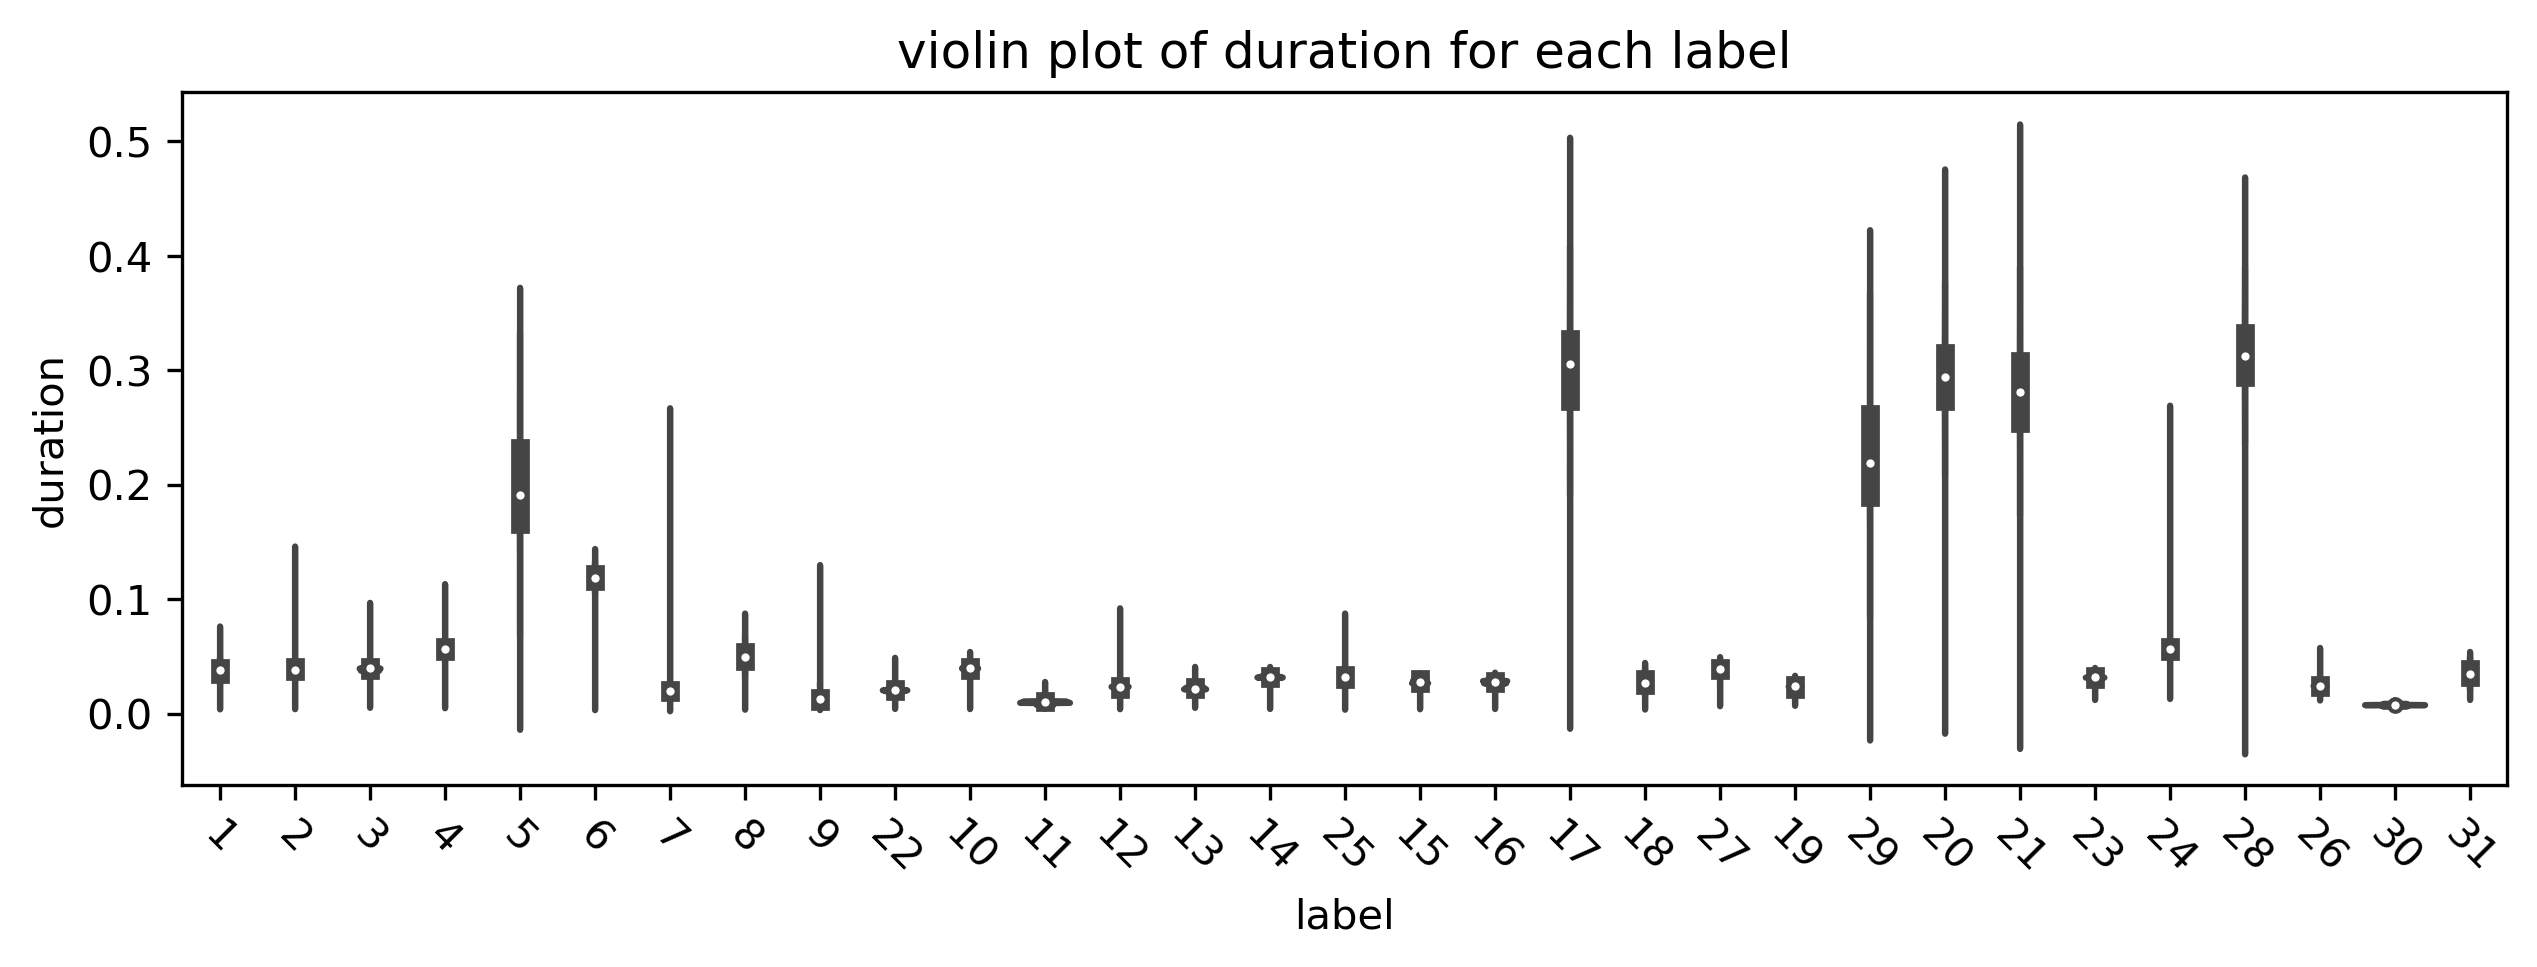

In [32]:
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
sns.violinplot(x ="label",y ="duration",data = df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = -45)
ax.set_title('violin plot of duration for each label')

In [33]:
more_data_path = r'C:\Users\sivanle.WISMAIN\Dropbox (Weizmann Institute)\lb4483\HandAnnotation_part1_lb4483_Vika.mat'

In [34]:
new_df = create_syl_df_from_annot_file(more_data_path)

In [35]:
new_df.head()

,path,label,duration,start,end,time_from_prev
0,lb4483_00001_2019_05_23_12_17_00.wav,3,0.041,3.966,4.007,NaN
1,lb4483_00001_2019_05_23_12_17_00.wav,3,0.026,4.048,4.074,0.041
2,lb4483_00001_2019_05_23_12_17_00.wav,3,0.026,4.121,4.147,0.047
3,lb4483_00001_2019_05_23_12_17_00.wav,3,0.029,4.193,4.222,0.046
4,lb4483_00001_2019_05_23_12_17_00.wav,3,0.032,4.266,4.298,0.044


Text(0.5, 1.0, 'labels histogram')

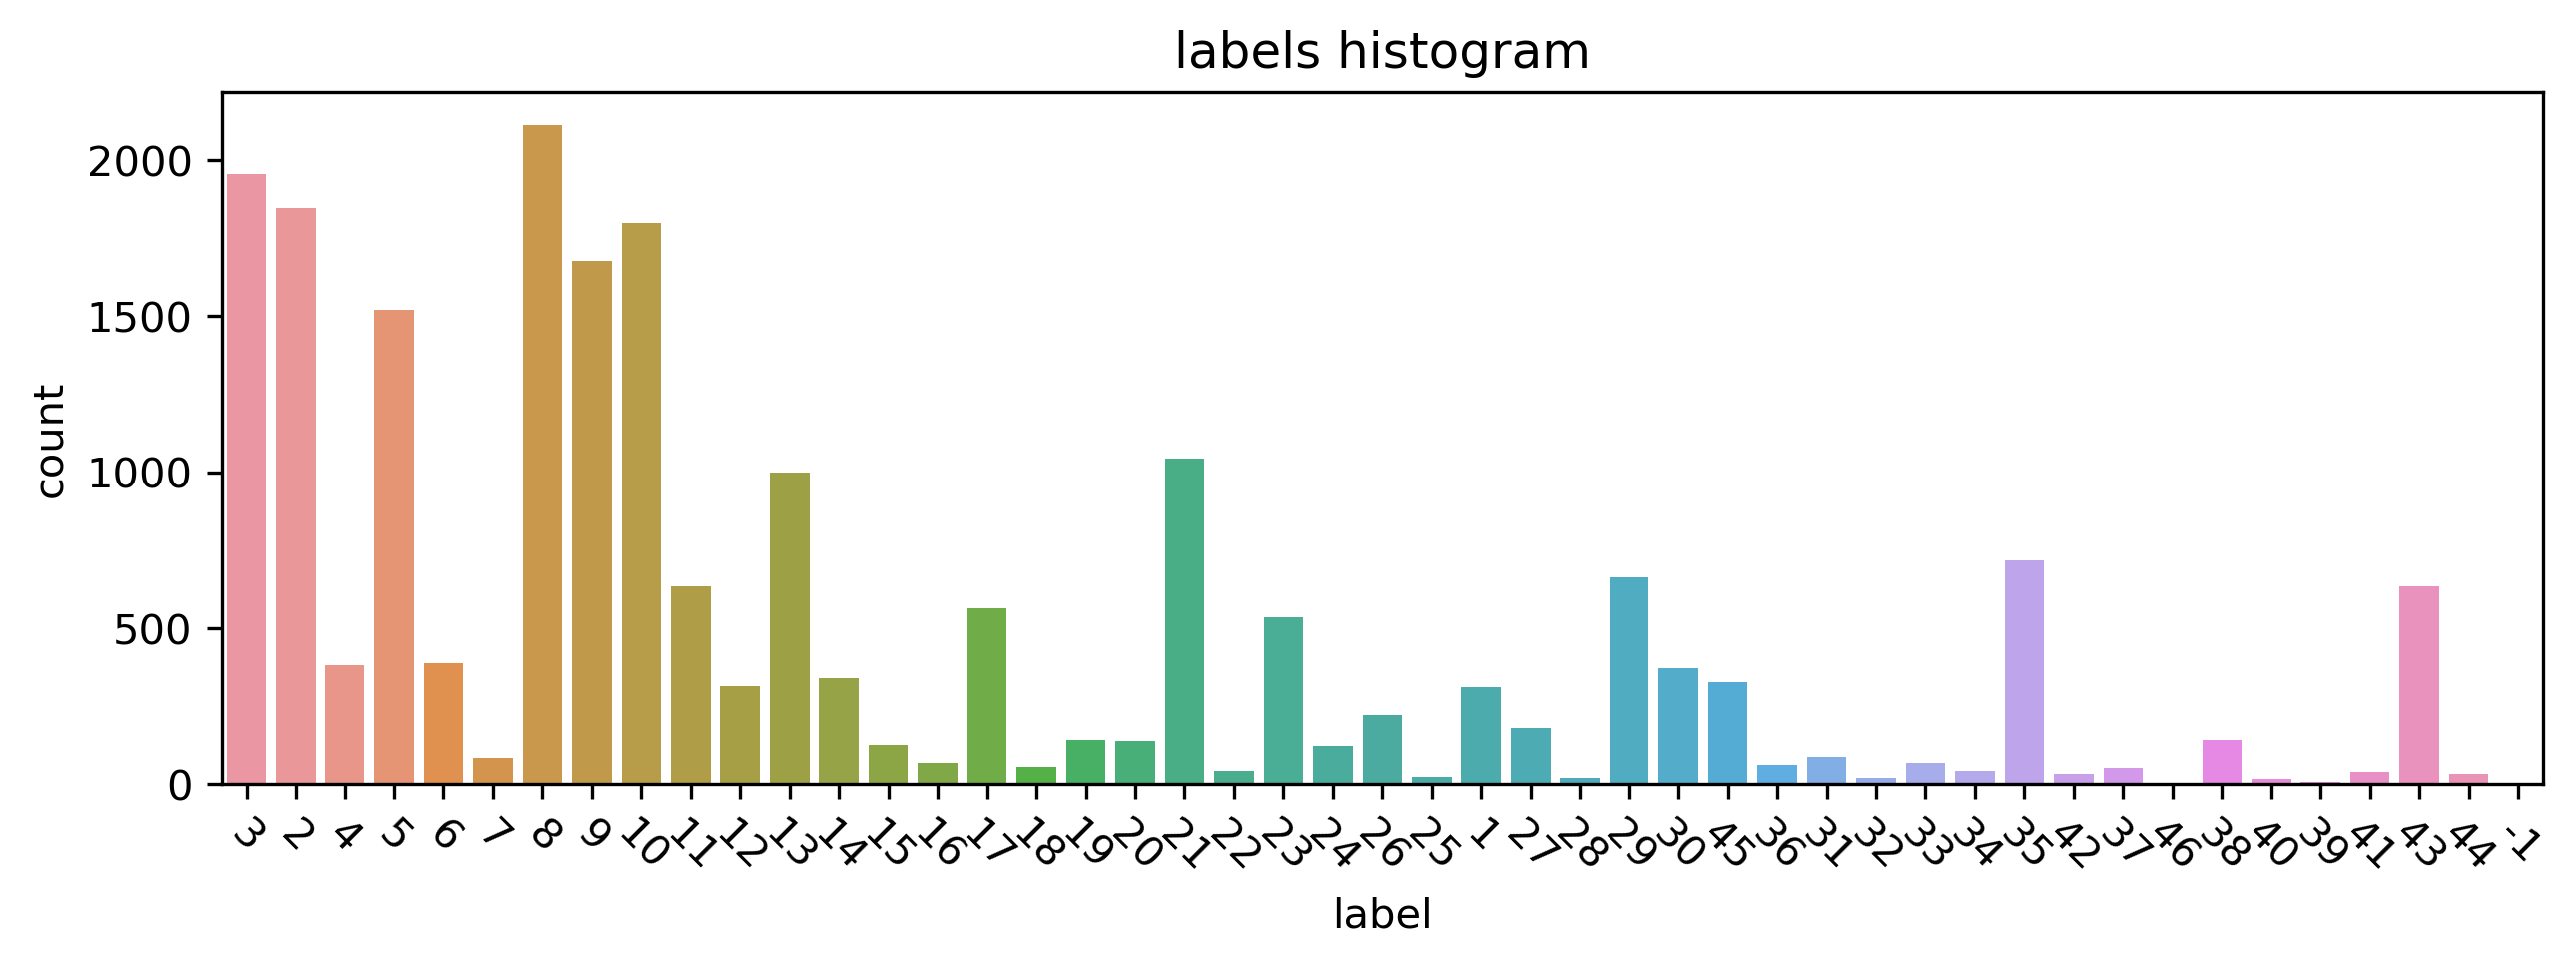

In [36]:
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
sns.countplot(data=new_df[['label']], x='label', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = -45)
ax.set_title('labels histogram')

### extracting songs

what does the function that converts annotations to strings of songs needs to do (according to the MATLAB code):
* being able to say that 2 or more syllabels are the same and treat them as such in the creation of the strings
* define phrases (same syllables with certain time aloud between them)
* define songs (a concatination of phrases with some time aloud between them)
* also maybe want to set syllabels to ignore? how to ignore them? just skip and start new songs if they are between syllabels that we are interested in?
* during the run of the function we want to save the dates from which each of the songs were recorded - maybe want to create a class or maybe a dict will be ebough?



In [37]:
df = create_syl_df_from_annot_file(data_path)

In [38]:
df.tail()

,path,label,duration,start,end,time_from_prev
1278386,lb4444_03928_2019_06_09_16_35_48.wav,26,0.026,14.303,14.329,0.018
1278387,lb4444_03928_2019_06_09_16_35_48.wav,26,0.027,14.344,14.371,0.015
1278388,lb4444_03928_2019_06_09_16_35_48.wav,26,0.026,14.385,14.411,0.014
1278389,lb4444_03928_2019_06_09_16_35_48.wav,26,0.023,14.430,14.453,0.019
1278390,lb4444_03928_2019_06_09_16_35_48.wav,26,0.017,14.472,14.489,0.019


In [39]:
def get_song_phrases_from_annotaion_file(annot_path, lim_phrase, lim_song, min_song_len, annot_to_ignore = [-1]):
    """
    This function returns a dictionary that contains songs from annotaion files. each entry in the array is the 
    songs extracted from a certain file.
    annot_path - path to mat annotation file
    lim_phrase - maximal inter-syllable separation within a phrase (sec) 
    lim_song - maximal inter-phrase separation within a bout (sec)
    min_song_len - the minimal length of songs we desire
    annot_to_ignore - an array of integers that are the values of annotations we want to ignore. currently 
                      ignoring an annotaion acts in the same rules as for other anntations, but it doesn't 
                      add a char to the the song string
                      
    """
    all_strings = {}
    
    #prepare the dataframe with the needed fields
    df = create_syl_df_from_annot_file(annot_path)
    df['datetime'] = df['path'].str.extract(r'(\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2})')
    df['file_num'] = df['path'].str.extract(r'(\d{5})')
    df['string_label'] =  df['label'].apply(lambda x: '' if int(x) in annot_to_ignore else ALPHAN_NUMERIC[int(x)-1])
    unique_file_nums = np.unique(df['file_num'])
    
    #go over all the files in the DF
    for j in tqdm(range(len(unique_file_nums))):
        curr_key = np.unique(df[df['file_num'] == unique_file_nums[j]]['datetime'])[0] +'#' +unique_file_nums[j]
        curr_file_string = "".join(df[df['file_num'] == unique_file_nums[j]]['string_label'].astype(str).array)
        start_index = df[df['file_num'] == unique_file_nums[j]]['string_label'].index[0]
        
        # find all the places where is took the bird longer than the limit for phrase to move to a different phrase
        results = np.where((df[df['file_num'] == unique_file_nums[j]]['time_from_prev']<lim_phrase).astype(int)==0)
        strings = []
        curr_str= ''
        
        if results[0].size == 1: # if there is no need to split the the file to differnt songs - baecause all 
            # gaps are below the desired limit
            for char in curr_file_string:
                        if not curr_str:
                            curr_str += char
                        elif char != curr_str[-1]:
                            curr_str += char
            if (len(curr_str) >= min_song_len):
                strings.append(curr_str)
            all_strings[curr_key] = strings
        else: # if we do have gaps that are larger than what we are willing to except we need to go over everything and find what splits we need to do:
                # is it a whole different song? or is it just a split in the phrase?
            for i in range(1,results[0].size):
                curr_time_from_prev = np.round(df[df['file_num'] == unique_file_nums[j]].loc[start_index+results[0][i]]['time_from_prev'],4)
                curr_set = set(curr_file_string[results[0][i-1]:results[0][i]])
                if curr_time_from_prev > lim_song: #check if the string we have so far needs to be a seperate song
                    if (len(curr_str) >= min_song_len):
                        strings.append(curr_str)
                    curr_str = ''
                    
                if (len(curr_set) == 1) and (curr_time_from_prev < lim_phrase):
                    curr_str += list(curr_set)[0]
                    split = True
                else:
                    for char in curr_file_string[results[0][i-1]:results[0][i]]:
                        if (not curr_str) or (split):
                            curr_str += char
                            split = False
                        elif char != curr_str[-1]:
                            curr_str += char
                    if (len(curr_str) >= min_song_len):
                        strings.append(curr_str)
                    curr_str = ''
            for char in curr_file_string[results[0][-1]:]: # go over the last idx of the results not
                        if (not curr_str) or (split):
                            curr_str += char
                            split = False
                        elif char != curr_str[-1]:
                            curr_str += char

            if (len(curr_str) >= min_song_len):
                strings.append(curr_str)
            if strings and strings[0]:
                all_strings[curr_key] = strings
            else:
                all_strings[curr_key] = strings[1:]
    return all_strings

In [40]:
def create_flat_list_from_dict(songs_dict):
    arr = [songs_dict[key] for key in songs_dict.keys()]
    flat_arr = [song for sublist in arr for song in sublist]
    return flat_arr

In [46]:
results_small_data = get_song_phrases_from_annotaion_file(more_data_path,0.25,0.5,4,[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
small_songs = create_flat_list_from_dict(results_small_data)

In [48]:
len(small_songs)

112

## Working with yaml config files

In [50]:
with open(r'C:\Users\sivanle.WISMAIN\Desktop\CohenLab\example_config.yaml') as f:
    config_example = yaml.load(f, Loader=SafeLoader)
    
    
# this is the contnet of this file - 
# ---
# # trying yaml file
#   PhraseLimitSeperationTime: 0.25
#   SongLimitSeperationTime: 0.5
#   MinSongLength: 2
#   AnnotationsToIgnore:
#    - -1 
# ...


In [51]:
results_small_data = get_song_phrases_from_annotaion_file(more_data_path,config_example['PhraseLimitSeperationTime'],config_example['SongLimitSeperationTime'],config_example['MinSongLength'],config_example['AnnotationsToIgnore'])

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
small_songs = create_flat_list_from_dict(results_small_data)
len(small_songs)

130